In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import linear_model
import warnings
import time
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

%matplotlib inline
t = time.time()

In [2]:
X=np.load('../../../input/nxtrain_standard_original0.npy')
X1= np.load('../../../input/nxtrain_standard_derived0.npy')
X2=pd.read_pickle("../../../input/time_series_derived_standard_train2.dat")
X3=pd.read_pickle("../../../input/time_series_original_standard_train2.dat")
X=np.hstack((X,X1,X2,X3))
y=pickle.load(open("../../../input/ytrain2.dat","rb"))

## Feature Selection for SDG Logistic regression

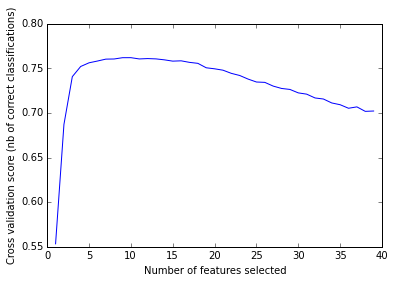

In [3]:
def scorer(estimator, X_test, y_test):
    preds_cv = estimator.predict_proba(X_test)[:,1]
    roc_auc=metrics.roc_auc_score(y_test, preds_cv)
    return roc_auc

clf = linear_model.SGDClassifier(loss='log',average=True,n_iter=40)
selector = RFECV(estimator=clf, step=40, cv=StratifiedKFold(y, 2),
              scoring=scorer,verbose=0)
selector1 = selector.fit(X, y)
# Plotting
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_)
plt.show()

## Prediction using SDG-Logistic regression

In [12]:
Xselect=X[:,selector1.support_]
clf = linear_model.SGDClassifier(loss='log',average=True,n_iter=500)
skf = cross_validation.StratifiedKFold(y, n_folds=2) # K-fold cv splitting
for train0, cv0 in skf:
    train, cv = train0, cv0
    break

MODEL = clf.fit(Xselect[train,:], y[train])
preds_cv = MODEL.predict_proba(Xselect[cv,:])[:,1]
AUC1=roc_auc=metrics.roc_auc_score(y[cv], preds_cv)
str1=time.strftime("%b%d%Y%H%M%S", time.localtime())
filename='../../../SDGLogistic_'  +  str1 + '_AUC_' + str(AUC1) + '.p'
np.arange(X.shape[1])[selector1.support_].dump(filename)

## Feature Selection for SDG Passive Aggressive Classfier

In [ ]:
clf= linear_model.PassiveAggressiveClassifier(loss='squared_hinge',C=1.0)
selector = RFECV(estimator=clf, step=100, cv=StratifiedKFold(y, 20),
              scoring='roc_auc',verbose=0)

selector1 = selector.fit(X, y)
Xselect=X[:,selector1.support_]

clf = linear_model.PassiveAggressiveClassifier(loss='squared_hinge',C=1.0)
skf = cross_validation.StratifiedKFold(y, n_folds=2) 

for train0, cv0 in skf:
    train, cv = train0, cv0
    break

niter=100
preds=0
ncount=0
for i in range(niter):
    MODEL = clf.fit(Xselect[train,:], y[train])
    pred0=MODEL.predict(Xselect[cv,:])
    preds=preds+pred0
    ncount+=1
        
preds=preds/float(ncount)
AUC1=metrics.roc_auc_score(y[cv], preds)

str1=time.strftime("%b%d%Y%H%M%S", time.localtime())
filename='../../../SDG_Aggressive_'  +  str1 + '_AUC_' + str(AUC1) + '.p'
np.arange(X.shape[1])[selector1.support_].dump(filename)

# Plotting
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_)
plt.show()
print(AUC1)

## Prediction using SDG SVM

In [ ]:
clf = linear_model.SGDClassifier()
selector = RFECV(estimator=clf, step=100, cv=StratifiedKFold(y, 10),
              scoring='roc_auc',verbose=0)

selector1 = selector.fit(X, y)

Xselect=X[:,selector1.support_]

clf = linear_model.SGDClassifier()
skf = cross_validation.StratifiedKFold(y, n_folds=5) # K-fold cv splitting

for train0, cv0 in skf:
    train, cv = train0, cv0
    break

niter=100
preds=0
ncount=0
for i in range(niter):
    MODEL = clf.fit(Xselect[train,:], y[train])
    pred0=MODEL.predict(Xselect[cv,:])
    preds=preds+pred0
    ncount+=1
        
preds=preds/float(ncount)
AUC1=metrics.roc_auc_score(y[cv], preds)


str1=time.strftime("%b%d%Y%H%M%S", time.localtime())
filename='SDGSVM_'  +  str1 + '_AUC_' + str(AUC1) + '.p'
np.arange(X.shape[1])[selector1.support_].dump(filename)

# Plotting
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_) + 1), selector1.grid_scores_)
plt.show()
print(AUC1)
elapsed = (time.time() - t)/60
print(elapsed)